# Generalized Sliced-Wasserstein Flows

The goal of this experiment is to illustrate the effects of the defining function choice in the Generalized Sliced-Wasserstein (GSW) and maximum Generalized Sliced-Wasserstein (max-GSW) distance.

## Experiment details

We consider the following problem:
$$\operatorname{min}_{p_Y} GSW_p(p_X, p_Y),$$

where $p_X$ is a target distribution and $p_Y$ is the source distribution, which is initialized to the normal distribution. 

The optimization is solved iteratively via
$$ \partial_t (p_Y)_t= -\nabla GSW_p(p_X, (p_Y)_t), ~~(p_Y)_0=\mathcal{N}(0, (0.25)^2).$$

We also consider $\operatorname{min}_{\mu} \{ \max\text{-}GSW_p(p_X, p_Y) \},$ and we use the same optimization scheme to solve it (with $\max\text{-}GSW_p$ in place of $GSW_p$). 

We use 5 well-known distributions as the target: the 25-Gaussians, 8-Gaussians, Swiss Roll, Half Moons and Circle distributions. We compare linear, homogeneous polynomial of degree 3 and homogeneous polynomial of degree 5 as defining functions.

We analyze the results (i) qualitatively, by plotting samples drawn from $p_X$ and $(p_Y)_t$ at each iteration $t$ of the optimization process, and (ii) quantitatively, by computing and reporting the 2-Wasserstein distance between $p_X$ and $(p_Y)_t$ at each $t$.

## Requirements

* Numpy
* Scikit-learn
* PyTorch
* POT

In [1]:
import sys
path_to_gsw='./gsw/'
sys.path.append(path_to_gsw)

import numpy as np
from gsw.gsw import GSW

from gsw_utils import w2,load_data

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function
from torch.nn.parameter import Parameter
from torch import optim

from tqdm import tqdm
from IPython import display
import time
import pickle 
import matplotlib.pyplot as plt
import random
import os

In [2]:
np.random.seed(10)

### We choose a dataset and load it
### The dataset name must be 'swiss_roll', 'half_moons', 'circle', '8gaussians' or '25gaussians'

In [3]:
dataset_name = 'swiss_roll'

In [4]:
N = 1000  # Number of samples from p_X
X = load_data(name=dataset_name, n_samples=N)
X -= X.mean(dim=0)[np.newaxis,:]  # Normalization
meanX = 0

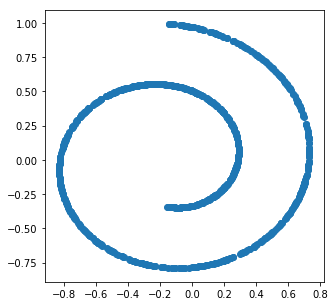

In [5]:
# Show the dataset
_, d = X.shape
fig = plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1])
plt.show()

### We create the different folders to store the results

In [6]:
results_folder = './saved_results_GSW_flows'
if not os.path.isdir(results_folder):
    os.mkdir(results_folder)

In [7]:
foldername = os.path.join(results_folder, 'Gifs')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

In [8]:
foldername = os.path.join(results_folder, 'Gifs', dataset_name + '_Comparison')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

### We solve the two optimization problems for different defining functions and plot the results at each step

In [9]:
# Use GPU if available, CPU otherwise
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [10]:
# Number of iterations for the optimization process
nofiterations = 250

In [11]:
# Define the variables to store the loss (2-Wasserstein distance) for each defining function and each problem 
w2_dist = np.nan * np.zeros((nofiterations, 3))
maxw2_dist = np.nan * np.zeros((nofiterations, 3))

In [12]:
# Define the different defining functions
modes = ['linear', 'poly', 'poly', 'linear', 'poly', 'poly']
titles = ['Linear', 'Poly 3', 'Poly 5', 'Max Linear', 'Max Poly 3', 'Max Poly 5']
degrees = [3, 3, 5, 3, 3, 5]

In [13]:
# Define the initial distribution
temp = np.random.normal(loc=meanX, scale=.25, size=(N,d))

# Define the optimizers
Y = list()
optimizer = list()
gsw = list()

for k in range(3):
    Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[k]], lr = 1e-2))
    gsw.append([GSW(ftype=modes[j], degree=degrees[j], nofprojections=1) for j in range(k+1)])

for k in range(3):
    Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[3 + k]], lr = 1e-2))
    gsw.append([GSW(ftype=modes[j], degree=degrees[j], nofprojections=1) for j in range(k+1)])


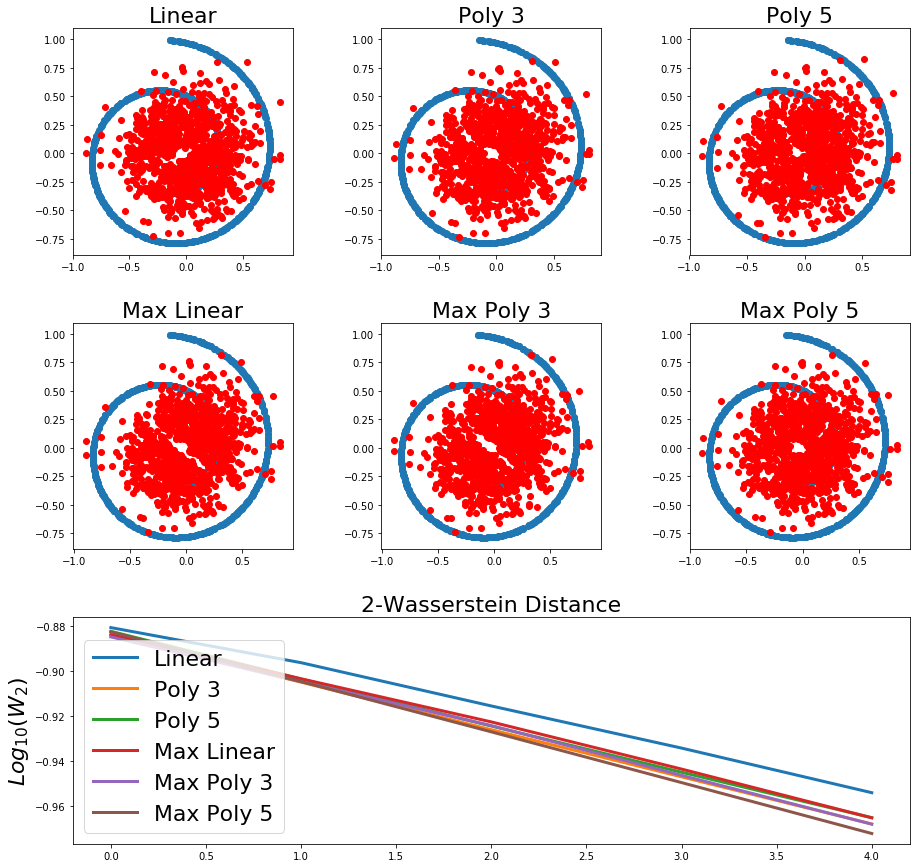

In [ ]:
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

for i in range(nofiterations):            
    loss = list()
    # We loop over the different defining functions for the GSW problem
    for k in range(3):
        # Loss computation (here, GSW)
        loss_ = 0
        for g in gsw[k]:
            loss_ += g.gsw(X.to(device),Y[k].to(device))
        
        # Optimization step
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        w2_dist[i, k] = w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())  
        
        # Plot samples from the target and the current solution
        temp = Y[k].detach().cpu().numpy()
        plt.subplot(grid[0, k])
        plt.scatter(X[:, 0], X[:, 1])
        plt.scatter(temp[:, 0], temp[:, 1], c='r') 
        plt.title(titles[k], fontsize=22)
    
    # We loop over the different defining functions for the max-GSW problem
    for k in range(3, 6):
        # Loss computation (here, max-GSW)
        loss_ = 0
        for g in gsw[k]:
            loss_ += g.max_gsw(X.to(device), Y[k].to(device), iterations=250, lr=1e-2)
        
        # Optimization step
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        maxw2_dist[i, k-3] = w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())  
        
        # Plot samples from the target and the current solution
        temp = Y[k].detach().cpu().numpy()
        plt.subplot(grid[1, k-3])
        plt.scatter(X[:,0], X[:,1])
        plt.scatter(temp[:,0], temp[:,1],c='r') 
        plt.title(titles[k], fontsize=22)    
        
    # Plot the 2-Wasserstein distance
    plt.subplot(grid[2, 0:3])
    plt.plot(np.log10(w2_dist[:,:]), linewidth=3)
    plt.plot(np.log10(maxw2_dist[:,:]), linewidth=3)
    plt.title('2-Wasserstein Distance', fontsize=22)
    plt.ylabel(r'$Log_{10}(W_2)$', fontsize=22)
         
    plt.legend(titles, fontsize=22, loc='lower left')
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(1e-5)
    
    # Save the figure 
    fig.savefig(foldername + '/img%03d.png'%(i))
    for k in range(3):
        plt.subplot(grid[:, k])
        plt.cla()


### We save the results

In [ ]:
filename = os.path.join(results_folder, dataset_name + '_comparison_1run.pkl')
with open(filename, 'wb') as f:
    pickle.dump([w2_dist, maxw2_dist], f)

In [ ]:
import imageio
from glob import glob
from skimage.transform import resize

In [ ]:
filenames = glob(foldername + '/*.png')
images = []
for filename in filenames:
    images.append(resize(imageio.imread(filename), (750, 750, 4)))
imageio.mimsave(dataset_name + '_comparison.gif', images)